<a href="https://colab.research.google.com/github/blourenco217/project_deep_learning/blob/main/resnet101rand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-e8441a21-dbad-769d-213b-1ea733e6d8d6)


In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download sachinkumar413/alzheimer-mri-dataset
! unzip alzheimer-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Non_Demented/non_1395.jpg  
  inflating: Dataset/Non_Demented/non_1396.jpg  
  inflating: Dataset/Non_Demented/non_1397.jpg  
  inflating: Dataset/Non_Demented/non_1398.jpg  
  inflating: Dataset/Non_Demented/non_1399.jpg  
  inflating: Dataset/Non_Demented/non_14.jpg  
  inflating: Dataset/Non_Demented/non_140.jpg  
  inflating: Dataset/Non_Demented/non_1400.jpg  
  inflating: Dataset/Non_Demented/non_1401.jpg  
  inflating: Dataset/Non_Demented/non_1402.jpg  
  inflating: Dataset/Non_Demented/non_1403.jpg  
  inflating: Dataset/Non_Demented/non_1404.jpg  
  inflating: Dataset/Non_Demented/non_1405.jpg  
  inflating: Dataset/Non_Demented/non_1406.jpg  
  inflating: Dataset/Non_Demented/non_1407.jpg  
  inflating: Dataset/Non_Demented/non_1408.jpg  
  inflating: Dataset/Non_Demented/non_1409.jpg  
  inflating: Dataset/Non_Demented/non_141.jpg  
  inflating: Dataset/Non_Demented/non_1410.jpg  
  inflating: Dataset/N

In [3]:
import numpy as np
import os
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import matplotlib
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input
from PIL import Image

In [4]:
def pad(img, h, w):
    #  in case when you have odd number
    top_pad = np.floor((h - img.shape[0]) / 2).astype(np.uint16)
    bottom_pad = np.ceil((h - img.shape[0]) / 2).astype(np.uint16)
    right_pad = np.ceil((w - img.shape[1]) / 2).astype(np.uint16)
    left_pad = np.floor((w - img.shape[1]) / 2).astype(np.uint16)
    return np.copy(np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant', constant_values=0))

def data_processing(dir_name):
    cwd = os.path.join(os.getcwd(), dir_name)
    path = os.path.join(cwd)
    files = os.listdir(path)
    x = []
    y = []
    class_names = ['verymild', 'non', 'mild', 'moderate']
    for file in files:
        figures = os.listdir(os.path.join(path, file))

        for figure in figures[0:]:
            try:
                with Image.open(os.path.join(os.path.join(path, file), figure)) as im:
                    x_single = np.stack((np.array(im),)*3, axis = -1)
                    x_single = pad(x_single, 224, 224)
                    x.append(x_single)
                    if figure.find('_') == -1:
                      y_single = class_names.index(figure.split('.')[0])
                    else:
                      y_single = class_names.index(figure.split('_')[0])
                    
                    y.append(y_single)
            except: pass
            
    x = np.array(x, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    x, y = shuffle(x, y, random_state=0)
    
    return x, y

x, y = data_processing('Dataset')

In [5]:
print(np.shape(x))
print(np.shape(y))

(6400, 224, 224, 3)
(6400,)


In [6]:
indices_train, indices_test = train_test_split(list(range(x.shape[0])), 
                                               train_size=0.8, 
                                               test_size=0.2, 
                                               shuffle=True)
x_train = x[indices_train]
y_train = y[indices_train]
x_test = x[indices_test]
y_test = y[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 224, 224, 3), (5120,), (1280, 224, 224, 3), (1280,))

In [7]:
# performing a one-hot encoding
y_train = keras.utils.np_utils.to_categorical(y_train, 4)
y_test = keras.utils.np_utils.to_categorical(y_test, 4)

y_train.shape, y_test.shape

((5120, 4), (1280, 4))

In [8]:
# performing data augmentation
datagen_train = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input, # image preprocessing function
    rotation_range = 10,                       # randomly rotate images in the range
    zoom_range = 0.1,                          # randomly zoom image
    width_shift_range = 0.1,                   # randomly shift images horizontally
    height_shift_range = 0.1,                  # randomly shift images vertically
    horizontal_flip = False,                    # randomly flip images horizontally
    vertical_flip = False,                     # randomly flip images vertically
    validation_split = 0.1
)
datagen_test = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input, # image preprocessing function
)

In [9]:
shape = (224, 224, 3)

# weights previously initialized from imagenet dataset
base_model = tf.keras.applications.ResNet101(input_shape = shape,
                                               include_top = False,
                                               weights = None)
# base_model.trainable = False
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(4, activation='softmax')
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  keras.layers.BatchNormalization(),  
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 256)               1

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
x_train.shape

(5120, 224, 224, 3)

In [13]:
checkpoint = keras.callbacks.ModelCheckpoint("mri_resnet101.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
history=model.fit(datagen_train.flow(x_train,y_train,
                                     batch_size = 32,
                                     subset = 'training'), 
                  epochs=100,
                  validation_data=datagen_train.flow(x_train, y_train, batch_size=8,subset='validation'), 
                  callbacks=[checkpoint,early] )

Epoch 1/100
144/144 [==============================] - ETA: 0s - loss: 1.0709 - accuracy: 0.5174
Epoch 1: val_accuracy improved from -inf to 0.48047, saving model to mri_resnet101.h5
144/144 [==============================] - 220s 1s/step - loss: 1.0709 - accuracy: 0.5174 - val_loss: 1.0611 - val_accuracy: 0.4805
Epoch 2/100
144/144 [==============================] - ETA: 0s - loss: 0.9368 - accuracy: 0.5412
Epoch 2: val_accuracy improved from 0.48047 to 0.52148, saving model to mri_resnet101.h5
144/144 [==============================] - 190s 1s/step - loss: 0.9368 - accuracy: 0.5412 - val_loss: 0.9744 - val_accuracy: 0.5215
Epoch 3/100
144/144 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.5566
Epoch 3: val_accuracy improved from 0.52148 to 0.52539, saving model to mri_resnet101.h5
144/144 [==============================] - 190s 1s/step - loss: 0.9281 - accuracy: 0.5566 - val_loss: 0.9593 - val_accuracy: 0.5254
Epoch 4/100
144/144 [============================

In [14]:
model.load_weights("mri_resnet101.h5")
test_loss, test_acc = model.evaluate(datagen_test.flow(x_test, y_test, batch_size=32), verbose=2)
print(test_acc)

40/40 - 15s - loss: 0.9590 - accuracy: 0.5320 - 15s/epoch - 386ms/step
0.532031238079071


Mounted at /content/gdrive


<Figure size 432x288 with 0 Axes>

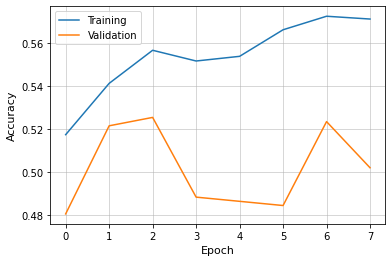

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')


fig = plt.figure()
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_xlabel("Epoch", fontsize=11)
ax.set_ylabel("Accuracy", fontsize=11)
ax.legend(("Training", "Validation"),loc="best", fontsize=10)
ax.grid(linewidth = 0.5)
fig.savefig('/content/gdrive/My Drive/resnet101_rand_imagenet.svg', format='svg', transparent=True)
fig.savefig('/content/gdrive/My Drive/resnet101_rand_imagenet.pdf', format='pdf', transparent=True)
# plt.show()

<Figure size 432x288 with 0 Axes>

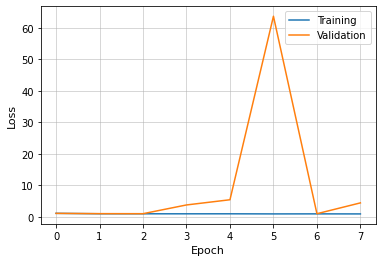

In [17]:
fig = plt.figure()
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel("Epoch", fontsize=11)
ax.set_ylabel("Loss", fontsize=11)
ax.legend(("Training", "Validation"),loc="best", fontsize=10)
ax.grid(linewidth = 0.5)
fig.savefig('/content/gdrive/My Drive/resnet101_rand_loss_imagenet.svg', format='svg', transparent=True)
fig.savefig('/content/gdrive/My Drive/resnet101_rand_loss_imagenet.pdf', format='pdf', transparent=True)